In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import HashingVectorizer

In [89]:
df=pd.read_csv("electronics-INDIA.csv")
products=["Vivo U20 (Blazing Blue, Snapdragon 675 AIE, 4GB RAM, 64GB Storage)", "Redmi Note 8 (Neptune Blue, 4GB RAM, 64GB Storage)", "Samsung Galaxy M30s (Blue, 4GB RAM, 64GB Storage)", "SanDisk Ultra Dual 64GB USB 3.0 OTG Pen Drive", "boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Raging Red)"]

features=['Product_Price','Product_Company','Product_Ratings','Product_Sold_By','Product_Title']

# df = df.dropna(axis=0, subset=['Product_Title'])

for feature in features:
    df[feature] = df[feature].fillna('')


 

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer 

In [4]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install unidecode

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /home/raghav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raghav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raghav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
import gzip
import gensim 
import logging


In [15]:
 def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [16]:
def tokenize(s1):
    word_list = nltk.word_tokenize(s1)
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output
    

In [17]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string
def pre_process(corpus):
    corpus = corpus.lower()
    stopset = stopwords.words('english') + list(string.punctuation)
    corpus = " ".join([i for i in word_tokenize(corpus) if i not in stopset])
    corpus = unidecode(corpus)
    return corpus


In [100]:
table_items=[]


In [101]:
for product in products:
    recommended_products=[]
    dataframe=df
    category=dataframe.loc[dataframe['Product_Title'] == product, 'Product_Category'].iloc[0]
    subcategory=dataframe.loc[dataframe['Product_Title'] == product, 'Product_Subcategory1'].iloc[0]
    dataframe = dataframe[dataframe['Product_Category']==category]
    dataframe = dataframe[dataframe['Product_Subcategory1']==subcategory]
    
    dataframe["combined_features"] = dataframe.Product_Title +" "+dataframe.Product_Company+" "+dataframe.Product_Ratings.map(str)+" "+dataframe.Product_Sold_By

    dataframe["combined_features"] = dataframe["combined_features"].apply(pre_process)
    length=len(dataframe["combined_features"])
      
    all_products_in_dataframe=list(enumerate(dataframe["Product_Title"]))
    for i in all_products_in_dataframe:
        if i[1] == product:
            index_of_product=i[0]
            break
            
    # 1 COSINE SIMILARITY COUNT VECTORIZER    
    cv = CountVectorizer()
    count_matrix = cv.fit_transform(dataframe["combined_features"] )

    cosine_sim = cosine_similarity(count_matrix)
    cosine_sim_similar_products =  list(enumerate(cosine_sim[index_of_product]))

    cosine_sim_sorted_order = sorted(cosine_sim_similar_products,key=lambda x:x[1],reverse=True)[1:]
    count_cosine_sim=0   
    
    print("Most recommended through Cosine Similarity\n")    
    w=""
    
    for element in cosine_sim_sorted_order:
        ans=all_products_in_dataframe[element[0]]
        if ans[0]==index_of_product:
            continue
        if count_cosine_sim is 5:
            break
        else:
            print(ans[1])
            w=w+ans[1]+"\n"
            count_cosine_sim=count_cosine_sim+1
            
    recommended_products.append(w)
    w=""
        
    # 2 COSINE SIMILARITY HASHING VECTORIZER 
    count_cosine_sim=0   
    vectorizer = HashingVectorizer(n_features=2**4)
    hasing_vector= vectorizer.fit_transform(dataframe["combined_features"])
    cosine_sim_hashing = cosine_similarity(hasing_vector)
    
    cosine_sim_hashing_similar_products =  list(enumerate(cosine_sim_hashing[index_of_product]))

    cosine_sim_hashing_sorted_order = sorted(cosine_sim_hashing_similar_products,key=lambda x:x[1],reverse=True)[1:]
    
    print("Most recommended through HASHING \n")    
    for element in cosine_sim_hashing_sorted_order:
        ans=all_products_in_dataframe[element[0]]
        if ans[0]==index_of_product:
            continue
        if count_cosine_sim is 5:
            break
        else:
            print(ans[1])
            w=w+ans[1]+"\n"
            count_cosine_sim=count_cosine_sim+1

    recommended_products.append(w)
    w=""      
    # 3 JACCARD INDEX 
    list_of_combines_test_features =  list(enumerate(dataframe["combined_features"]))
    main_list = list_of_combines_test_features[index_of_product][1].split()

    rows, cols = (2, length) 
    solution=[] 


    for i in range(0,length):
        col = [] 
        if(i==index_of_product):
            continue
        else:   
            score=jaccard_similarity(main_list,list_of_combines_test_features[i][1].split())
            col.append(score) 
            col.append(all_products_in_dataframe[i][1]) 
            solution.append(col) 


    solution = sorted(solution,key=lambda x:x[0],reverse=True)   
    count_of_jaccard_products=0

    print("Most recommended through Jaccard Index\n")

    for i in range(0, len(solution)):
        s=solution[i][1]
        if count_of_jaccard_products is 5:
            break
        if(s is np.nan):
            continue
        else:
            print(s)
            w=w+s+"\n"
            count_of_jaccard_products=count_of_jaccard_products+1
            
    recommended_products.append(w)
    w="" 
        
        
        
    # 4 COSINE SIMILARITY USING TF-IDF
    
    tfidf_vectorizer = TfidfVectorizer()
    tf_idf_matrix=tfidf_vectorizer.fit_transform(list(dataframe["combined_features"]))
    tf_idf=cosine_similarity(tf_idf_matrix)
    tf_idf_similar_products =  list(enumerate(tf_idf[index_of_product]))

    tf_idf_sorted_order = sorted(tf_idf_similar_products,key=lambda x:x[1],reverse=True)[1:]
    count_cosine_sim=0   
    
    print("Most recommended through TF-IDF\n")    
    
    for element in tf_idf_sorted_order:
        ans=all_products_in_dataframe[element[0]]
        if ans[0]==index_of_product:
            continue
        if count_cosine_sim is 5:
            break
        else:
            print(ans[1])
            w=w+ans[1]+"\n"
            count_cosine_sim=count_cosine_sim+1
            
    recommended_products.append(w)
    w="" 



    # 5 WORD2VEC
    dataset=[]
    for i in dataframe['combined_features']:
        dataset.append(list(i.split()))
        
    for i in list_of_combines_test_features:
        dataset.append(list(i[1].split()))

    m = gensim.models.Word2Vec (dataset, size=150, window=10, min_count=2, workers=10)
    m.train(dataset,total_examples=len(dataset),epochs=10)

    
    main_list = list_of_combines_test_features[index_of_product][1]
    rows, cols = (2, length) 
    solution=[] 
    
    for i in range(0,length):
        col = [] 
        if(i==index_of_product):
            continue
        else:   
            distance = m.wv.n_similarity(main_list.lower().split(), list_of_combines_test_features[i][1].lower().split())
            col.append(distance) 
            col.append(all_products_in_dataframe[i][1]) 
            solution.append(col) 
    
    solution = sorted(solution,key=lambda x:x[0],reverse=True)   
    
    count_of_word2vec=0

    print("Most recommended through WORD2VEC\n")

    for i in range(0, len(solution)):
        s=solution[i][1]
        if count_of_word2vec is 5:
            break
        if(s is np.nan):
            continue
        else:
            print(s)
            w=w+s+"\n"
            count_of_word2vec=count_of_word2vec+1
            
            
    recommended_products.append(w)
    table_items.append(recommended_products)
    w="" 
        


2020-05-16 02:36:01,377 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-05-16 02:36:01,378 : INFO : collecting all words and their counts
2020-05-16 02:36:01,379 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-16 02:36:01,380 : INFO : collected 120 word types from a corpus of 1374 raw words and 90 sentences
2020-05-16 02:36:01,382 : INFO : Loading a fresh vocabulary
2020-05-16 02:36:01,383 : INFO : effective_min_count=2 retains 120 unique words (100% of original 120, drops 0)
2020-05-16 02:36:01,383 : INFO : effective_min_count=2 leaves 1374 word corpus (100% of original 1374, drops 0)
2020-05-16 02:36:01,385 : INFO : deleting the raw counts dictionary of 120 items
2020-05-16 02:36:01,385 : INFO : sample=0.001 downsamples 87 most-common words
2020-05-16 02:36:01,388 : INFO : downsampling leaves estimated 547 word corpus (39.8% of prior 1374)
2020-05-16 02:36:01,389 : INFO : estimated required memory for 120 word

Most recommended through Cosine Similarity

Vivo U20 (Blazing Blue, Snapdragon 675 AIE, 6GB RAM, 64GB
Vivo U20 (Racing Black, Snapdragon 675 AIE, 6GB RAM, 64GB Storage)
Vivo U10 (Electric Blue, 5000 mAH 18W Fast Charge Battery, 4GB RAM, 64GB Storage)
Vivo U10 (Electric Blue, 5000 mAH 18W Fast Charge Battery, 3GB RAM, 32GB Storage)
OPPO A7 (Glaze Blue, 3GB RAM, 64GB Storage) with No Cost EMI/Additional Exchange Offers
Most recommended through HASHING 

Vivo U20 (Blazing Blue, Snapdragon 675 AIE, 6GB RAM, 64GB
Vivo U10 (Electric Blue, 5000 mAH 18W Fast Charge Battery, 4GB RAM, 64GB Storage)
Vivo U20 (Racing Black, Snapdragon 675 AIE, 6GB RAM, 64GB Storage)
Vivo U10 (Electric Blue, 5000 mAH 18W Fast Charge Battery, 3GB RAM, 32GB Storage)
OPPO F11 (Marble Green, 6GB RAM, 128GB Storage) with No Cost EMI/Additional Exchange Offers
Most recommended through Jaccard Index

Vivo U20 (Blazing Blue, Snapdragon 675 AIE, 6GB RAM, 64GB
Vivo U20 (Racing Black, Snapdragon 675 AIE, 6GB RAM, 64GB Storage

2020-05-16 02:36:01,568 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-05-16 02:36:01,569 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:01,570 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-16 02:36:01,571 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:01,572 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:01,572 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:01,573 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:01,573 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:01,574 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:01,575 : INFO : EPOCH - 1 : training on 1374 raw words (533 effective words) took 0.0s, 63580 effective words/s
2020-05-16 02:36:01,583 : INFO : worker thread finis

2020-05-16 02:36:01,734 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-05-16 02:36:01,735 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-05-16 02:36:01,736 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:01,737 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-16 02:36:01,737 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:01,738 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:01,738 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:01,739 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:01,739 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:01,740 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:01,740 : INFO : EPOCH - 9 : training on 1374 raw words (540 effective wor

Most recommended through WORD2VEC

Vivo U20 (Blazing Blue, Snapdragon 675 AIE, 6GB RAM, 64GB
Vivo U20 (Racing Black, Snapdragon 675 AIE, 6GB RAM, 64GB Storage)
Vivo U10 (Electric Blue, 5000 mAH 18W Fast Charge Battery, 4GB RAM, 64GB Storage)
Vivo U10 (Electric Blue, 5000 mAH 18W Fast Charge Battery, 3GB RAM, 32GB Storage)
OPPO A7 (Glaze Blue, 3GB RAM, 64GB Storage) with No Cost EMI/Additional Exchange Offers


2020-05-16 02:36:02,590 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-05-16 02:36:02,591 : INFO : collecting all words and their counts
2020-05-16 02:36:02,592 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-16 02:36:02,593 : INFO : collected 120 word types from a corpus of 1374 raw words and 90 sentences
2020-05-16 02:36:02,594 : INFO : Loading a fresh vocabulary
2020-05-16 02:36:02,597 : INFO : effective_min_count=2 retains 120 unique words (100% of original 120, drops 0)
2020-05-16 02:36:02,597 : INFO : effective_min_count=2 leaves 1374 word corpus (100% of original 1374, drops 0)
2020-05-16 02:36:02,598 : INFO : deleting the raw counts dictionary of 120 items
2020-05-16 02:36:02,599 : INFO : sample=0.001 downsamples 87 most-common words
2020-05-16 02:36:02,600 : INFO : downsampling leaves estimated 547 word corpus (39.8% of prior 1374)
2020-05-16 02:36:02,600 : INFO : estimated required memory for 120 word

2020-05-16 02:36:02,759 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:02,760 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:02,761 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:02,763 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:02,764 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:02,765 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:02,765 : INFO : EPOCH - 2 : training on 1374 raw words (562 effective words) took 0.0s, 52439 effective words/s
2020-05-16 02:36:02,771 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-05-16 02:36:02,772 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-05-16 02:36:02,773 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:02,773 : INFO : worker thread finis

Most recommended through Cosine Similarity

Redmi Note 8 (Moonlight White, 4GB RAM, 64GB Storage)
Redmi Note 8 (Space Black, 4GB RAM, 64GB Storage)
Redmi Note 8 (Neptune Blue, 6GB RAM, 128GB Storage) - Extra 1,000 Off on Exchange & 6 Month No Cost EMI
Redmi 7A (Matte Blue, 2GB RAM, 32GB Storage)
Redmi Note 8 Pro (Halo White, 6GB RAM, 64GB Storage with Helio G90T Processor) - 6 Month No Cost EMI
Most recommended through HASHING 

Redmi Note 8 (Moonlight White, 4GB RAM, 64GB Storage)
Redmi Note 8 (Space Black, 4GB RAM, 64GB Storage)
Redmi Note 8 (Neptune Blue, 6GB RAM, 128GB Storage) - Extra 1,000 Off on Exchange & 6 Month No Cost EMI


Most recommended through Jaccard Index

Redmi Note 8 (Moonlight White, 4GB RAM, 64GB Storage)
Redmi Note 8 (Space Black, 4GB RAM, 64GB Storage)
Redmi Note 8 (Neptune Blue, 6GB RAM, 128GB Storage) - Extra 1,000 Off on Exchange & 6 Month No Cost EMI
Redmi Note 8 (Moonlight White, 6GB RAM, 128GB Storage) - Extra 1,000 Off on Exchange & 6 Month No Cost EMI
Re

2020-05-16 02:36:02,784 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-05-16 02:36:02,785 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-05-16 02:36:02,787 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:02,788 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-16 02:36:02,789 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:02,790 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:02,791 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:02,791 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:02,792 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:02,793 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:02,794 : INFO : EPOCH - 4 : training on 1374 raw words (572 effective wor

Most recommended through WORD2VEC

Redmi Note 8 (Space Black, 4GB RAM, 64GB Storage)
Redmi Note 8 (Moonlight White, 4GB RAM, 64GB Storage)
Redmi Note 8 (Neptune Blue, 6GB RAM, 128GB Storage) - Extra 1,000 Off on Exchange & 6 Month No Cost EMI
Redmi Note 8 (Moonlight White, 6GB RAM, 128GB Storage) - Extra 1,000 Off on Exchange & 6 Month No Cost EMI
Redmi Note 8 (Cosmic Purple, 6GB RAM, 128GB Storage) - Extra 1,000 Off on Exchange & 6 Month No Cost EMI


2020-05-16 02:36:03,720 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-05-16 02:36:03,722 : INFO : collecting all words and their counts
2020-05-16 02:36:03,722 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-16 02:36:03,724 : INFO : collected 120 word types from a corpus of 1374 raw words and 90 sentences
2020-05-16 02:36:03,724 : INFO : Loading a fresh vocabulary
2020-05-16 02:36:03,726 : INFO : effective_min_count=2 retains 120 unique words (100% of original 120, drops 0)
2020-05-16 02:36:03,726 : INFO : effective_min_count=2 leaves 1374 word corpus (100% of original 1374, drops 0)
2020-05-16 02:36:03,727 : INFO : deleting the raw counts dictionary of 120 items
2020-05-16 02:36:03,728 : INFO : sample=0.001 downsamples 87 most-common words
2020-05-16 02:36:03,729 : INFO : downsampling leaves estimated 547 word corpus (39.8% of prior 1374)
2020-05-16 02:36:03,730 : INFO : estimated required memory for 120 word

2020-05-16 02:36:03,894 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:03,895 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:03,895 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:03,896 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:03,898 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:03,899 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:03,899 : INFO : EPOCH - 2 : training on 1374 raw words (562 effective words) took 0.0s, 41269 effective words/s
2020-05-16 02:36:03,904 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-05-16 02:36:03,904 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-05-16 02:36:03,905 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:03,906 : INFO : worker thread finis

Most recommended through Cosine Similarity

Samsung Galaxy M30s (White, 4GB RAM, 64GB Storage)
Samsung Galaxy M30s (Opal Black, 4GB RAM, 64GB Storage)
Samsung Galaxy M30s (Blue, 6GB RAM, 128GB Storage)
Samsung Galaxy M20 (Ocean Blue , 4GB RAM, 64GB Storage, 5000mAH Battery)
Samsung Galaxy M30 (Gradation Blue, 4GB RAM, Super AMOLED Display, 64GB Storage, 5000mAH Battery)
Most recommended through HASHING 

Samsung Galaxy M30s (White, 4GB RAM, 64GB Storage)
Samsung Galaxy M20 (Ocean Blue , 4GB RAM, 64GB Storage, 5000mAH Battery)
Samsung Galaxy M30s (Opal Black, 4GB RAM, 64GB Storage)
Samsung Galaxy M30 (Gradation Blue, 4GB RAM, Super AMOLED Display, 64GB Storage, 5000mAH Battery)
Samsung Galaxy M30 (Gradation Blue, 4GB RAM, Super AMOLED Display, 64GB Storage, 5000mAH Battery)
Most recommended through Jaccard Index

Samsung Galaxy M30s (White, 4GB RAM, 64GB Storage)
Samsung Galaxy M30s (Opal Black, 4GB RAM, 64GB Storage)
Samsung Galaxy M30s (Blue, 6GB RAM, 128GB Storage)
Samsung Galaxy M20

2020-05-16 02:36:03,917 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-05-16 02:36:03,918 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-05-16 02:36:03,921 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:03,921 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-16 02:36:03,922 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:03,923 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:03,924 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:03,925 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:03,925 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:03,927 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:03,932 : INFO : EPOCH - 4 : training on 1374 raw words (572 effective wor

Most recommended through WORD2VEC

Samsung Galaxy M30s (White, 4GB RAM, 64GB Storage)
Samsung Galaxy M30s (Opal Black, 4GB RAM, 64GB Storage)
Samsung Galaxy M30s (Blue, 6GB RAM, 128GB Storage)
Samsung Galaxy M20 (Ocean Blue , 4GB RAM, 64GB Storage, 5000mAH Battery)
Samsung Galaxy M30s (Opal Black, 6GB RAM, 128GB Storage)


2020-05-16 02:36:04,977 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-05-16 02:36:04,978 : INFO : collecting all words and their counts
2020-05-16 02:36:04,979 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-16 02:36:04,979 : INFO : collected 52 word types from a corpus of 416 raw words and 30 sentences
2020-05-16 02:36:04,980 : INFO : Loading a fresh vocabulary
2020-05-16 02:36:04,981 : INFO : effective_min_count=2 retains 52 unique words (100% of original 52, drops 0)
2020-05-16 02:36:04,982 : INFO : effective_min_count=2 leaves 416 word corpus (100% of original 416, drops 0)
2020-05-16 02:36:04,983 : INFO : deleting the raw counts dictionary of 52 items
2020-05-16 02:36:04,990 : INFO : sample=0.001 downsamples 52 most-common words
2020-05-16 02:36:04,992 : INFO : downsampling leaves estimated 105 word corpus (25.3% of prior 416)
2020-05-16 02:36:04,993 : INFO : estimated required memory for 52 words and 150

2020-05-16 02:36:05,143 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:05,144 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:05,144 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:05,145 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:05,146 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:05,161 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:05,162 : INFO : EPOCH - 2 : training on 416 raw words (101 effective words) took 0.0s, 4063 effective words/s


Most recommended through Cosine Similarity

SanDisk Ultra Dual 64GB USB 3.0 OTG Pen Drive (Gold)
SanDisk Ultra Dual 32GB USB 3.0 OTG Pen Drive (Gold)
SanDisk Cruzer Blade 64GB USB 2.0 Flash Drive
SanDisk Ultra Dual SDDD3-128G-I35 USB 3.0 128GB Flash Drive
SanDisk Cruzer Blade 32GB USB Flash Drive
Most recommended through HASHING 

SanDisk Ultra Dual 64GB USB 3.0 OTG Pen Drive (Gold)
SanDisk Ultra Dual 32GB USB 3.0 OTG Pen Drive (Gold)
HP FD236W 32GB USB 2.0 Pen Drive (Gray)
SanDisk Ultra Dual SDDD3-128G-I35 USB 3.0 128GB Flash Drive
HP v236w 16GB USB 2.0 Pen Drive
Most recommended through Jaccard Index

SanDisk Ultra Dual 64GB USB 3.0 OTG Pen Drive (Gold)
SanDisk Ultra Dual 32GB USB 3.0 OTG Pen Drive (Gold)
SanDisk Ultra Dual SDDD3-128G-I35 USB 3.0 128GB Flash Drive
SanDisk Cruzer Blade 64GB USB 2.0 Flash Drive
SanDisk Cruzer Blade SDCZ50-016G-135 16GB USB 2.0 Pen Drive
Most recommended through TF-IDF

SanDisk Ultra Dual 64GB USB 3.0 OTG Pen Drive (Gold)
SanDisk Ultra Dual 32GB USB 3.0

2020-05-16 02:36:05,174 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-05-16 02:36:05,175 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-05-16 02:36:05,176 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:05,177 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-16 02:36:05,178 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:05,180 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:05,183 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:05,184 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:05,185 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:05,185 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:05,186 : INFO : EPOCH - 3 : training on 416 raw words (108 effective word

2020-05-16 02:36:05,322 : INFO : training on a 4160 raw words (1074 effective words) took 0.2s, 4990 effective words/s
2020-05-16 02:36:05,322 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


Most recommended through WORD2VEC

SanDisk Ultra Dual 64GB USB 3.0 OTG Pen Drive (Gold)
SanDisk Ultra Dual 32GB USB 3.0 OTG Pen Drive (Gold)
SanDisk Ultra Dual SDDD3-128G-I35 USB 3.0 128GB Flash Drive
SanDisk Cruzer Blade 64GB USB 2.0 Flash Drive
SanDisk Cruzer Blade SDCZ50-016G-135 16GB USB 2.0 Pen Drive


2020-05-16 02:36:06,198 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-05-16 02:36:06,199 : INFO : collecting all words and their counts
2020-05-16 02:36:06,200 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-16 02:36:06,201 : INFO : collected 261 word types from a corpus of 2984 raw words and 176 sentences
2020-05-16 02:36:06,201 : INFO : Loading a fresh vocabulary
2020-05-16 02:36:06,202 : INFO : effective_min_count=2 retains 261 unique words (100% of original 261, drops 0)
2020-05-16 02:36:06,203 : INFO : effective_min_count=2 leaves 2984 word corpus (100% of original 2984, drops 0)
2020-05-16 02:36:06,204 : INFO : deleting the raw counts dictionary of 261 items
2020-05-16 02:36:06,205 : INFO : sample=0.001 downsamples 80 most-common words
2020-05-16 02:36:06,206 : INFO : downsampling leaves estimated 1523 word corpus (51.0% of prior 2984)
2020-05-16 02:36:06,209 : INFO : estimated required memory for 261 wo

Most recommended through Cosine Similarity

boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Neon)
boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Active Black)
boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Ocean Blue)
Boat Rockerz 255 Pro Fast Charging Bluetooth Headset (Raging Red)
boAt Rockerz 261 Sport Wireless Earphones (Raging Red)
Most recommended through HASHING 

boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Neon)
boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Ocean Blue)
boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Active Black)
boAt BassHeads 225 Special Edition in-Ear Headphones with Mic and Carrying Case (Blue)
boAt BassHeads 225 Special Edition in-Ear Headpho

2020-05-16 02:36:06,388 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:06,388 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-16 02:36:06,389 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:06,390 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:06,391 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:06,391 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:06,393 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:06,394 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:06,394 : INFO : EPOCH - 1 : training on 2984 raw words (1525 effective words) took 0.0s, 149067 effective words/s
2020-05-16 02:36:06,406 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-05-16 02:36:06,408 : INFO : worker thread fin

2020-05-16 02:36:06,543 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-05-16 02:36:06,544 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-16 02:36:06,545 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-16 02:36:06,546 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-16 02:36:06,548 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-16 02:36:06,551 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-16 02:36:06,552 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-16 02:36:06,556 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-16 02:36:06,557 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-16 02:36:06,558 : INFO : EPOCH - 9 : training on 2984 raw words (1530 effective words) took 0.0s, 85108 effective words/s
2020-05-16 02:36:06,572 : INFO : worker thread fini

Most recommended through WORD2VEC

boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Neon)
boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Active Black)
boAt Rockerz 255 Sports Bluetooth Wireless Earphone with Immersive Stereo Sound and Hands Free Mic (Ocean Blue)
Boat Rockerz 255 Pro Fast Charging Bluetooth Headset (Raging Red)
boAt Rockerz 261 Sport Wireless Earphones (Raging Red)


In [107]:
for i in range(0, len(table_items)):
    print(table_items[i][0])
    print('\n')

Vivo U20 (Blazing Blue, Snapdragon 675 AIE, 6GB RAM, 64GB
Vivo U20 (Racing Black, Snapdragon 675 AIE, 6GB RAM, 64GB Storage)
Vivo U10 (Electric Blue, 5000 mAH 18W Fast Charge Battery, 4GB RAM, 64GB Storage)
Vivo U10 (Electric Blue, 5000 mAH 18W Fast Charge Battery, 3GB RAM, 32GB Storage)
OPPO A7 (Glaze Blue, 3GB RAM, 64GB Storage) with No Cost EMI/Additional Exchange Offers



Redmi Note 8 (Moonlight White, 4GB RAM, 64GB Storage)
Redmi Note 8 (Space Black, 4GB RAM, 64GB Storage)
Redmi Note 8 (Neptune Blue, 6GB RAM, 128GB Storage) - Extra 1,000 Off on Exchange & 6 Month No Cost EMI
Redmi 7A (Matte Blue, 2GB RAM, 32GB Storage)
Redmi Note 8 Pro (Halo White, 6GB RAM, 64GB Storage with Helio G90T Processor) - 6 Month No Cost EMI



Samsung Galaxy M30s (White, 4GB RAM, 64GB Storage)
Samsung Galaxy M30s (Opal Black, 4GB RAM, 64GB Storage)
Samsung Galaxy M30s (Blue, 6GB RAM, 128GB Storage)
Samsung Galaxy M20 (Ocean Blue , 4GB RAM, 64GB Storage, 5000mAH Battery)
Samsung Galaxy M30 (Gradation Bl

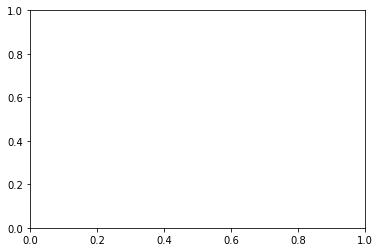

In [110]:
import matplotlib.pyplot as plt
from platform import python_version as pythonversion
from matplotlib import __version__ as matplotlibversion
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
y = [1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1]    
col_labels = ['Count_Vectorizer', 'Hashing', 'Jaccard_Index', 'Tf-Idf', 'Word2Vec']
row_labels=[]

for product in products:
    row_labels.append(product)
    
# print(row_labels)


# table_vals =[[table_items[0][0], table_items[0][0], table_items[0][0], table_items[0][0],], [21, 22, 23], [31, 32, 33]]

# for i in range(0, len(table_items)):
#     print(table_items[i][0])
#     print('\n')

# # Draw table
# the_table = plt.table(cellText=table_items,
#                       colWidths=[0.1] * 3,
#                       rowLabels=row_labels,
#                       colLabels=col_labels,
#                       loc='center')
# the_table.auto_set_font_size(False)
# the_table.set_fontsize(24)
# the_table.scale(10, 10)

# # Removing ticks and spines enables you to get the figure only with table
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
# for pos in ['right','top','bottom','left']:
#     plt.gca().spines[pos].set_visible(False)
# plt.savefig('matplotlib-table.png', bbox_inches='tight', pad_inches=0.05)

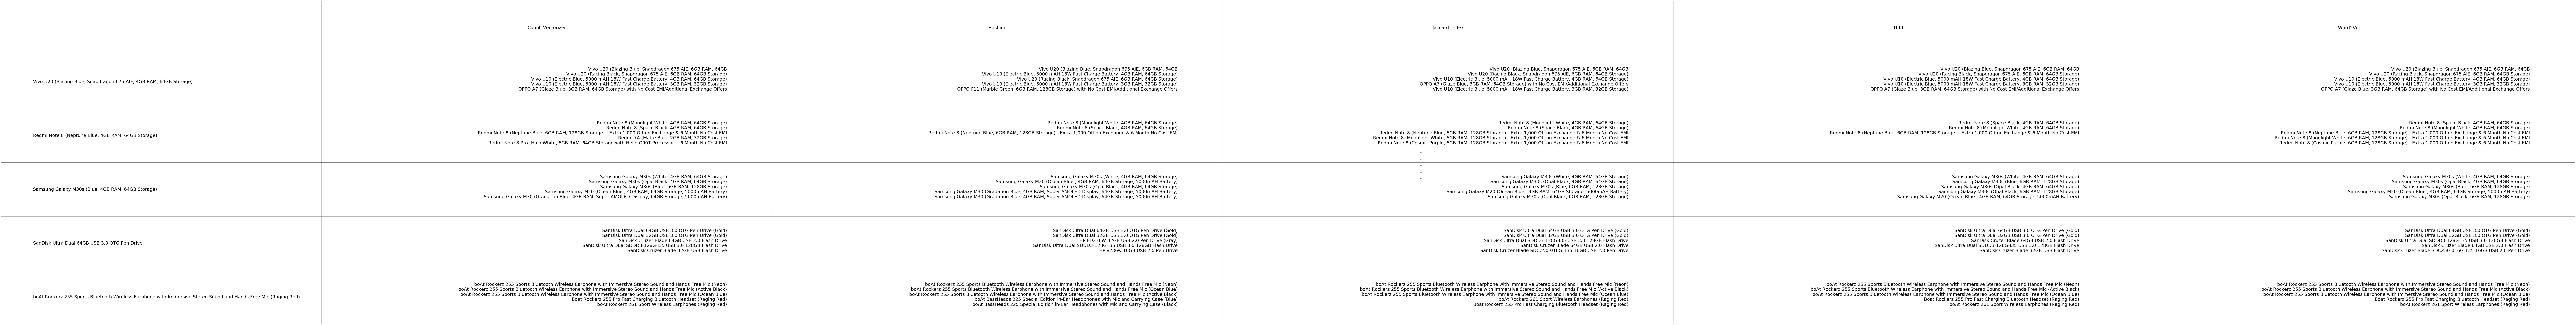

In [141]:
import matplotlib.pyplot as plt
from platform import python_version as pythonversion
from matplotlib import __version__ as matplotlibversion
%matplotlib inline


fig = plt.figure()
ax = fig.add_subplot(111)
y = [1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1,3]    
col_labels = ['Count_Vectorizer', 'Hashing', 'Jaccard_Index', 'Tf-Idf', 'Word2Vec']
row_labels=[]

for product in products:
    row_labels.append(product)
    
# table_vals = [[table_items[0][0], 12, 13,12], [21, 22, 23,12], [31, 32, 33,12], [31, 32, 33,12], [31, 32, 33,12]]


table_vals = [[table_items[0][0], table_items[0][1], table_items[0][2],table_items[0][3], table_items[0][4]], [table_items[1][0], table_items[1][1], table_items[1][2],table_items[1][3], table_items[1][4]], [table_items[2][0], table_items[2][1], table_items[2][2],table_items[2][3], table_items[2][4]], [table_items[3][0], table_items[3][1], table_items[3][2],table_items[3][3], table_items[3][4]], [table_items[4][0], table_items[4][1], table_items[4][2],table_items[4][3], table_items[4][4]]]
# Draw table
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.3] * 400,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(30)
the_table.scale(30, 30)

# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both')
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.savefig('matplotlib-table.png', bbox_inches='tight', pad_inches=0.5)